## Runnning with gammapy-dev/IRF_model
Fitting asimov datasets with nuisance parameters based on the different livetimes

### Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets, FluxPointsDataset
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SkyModel,
    PointSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    PiecewiseNormSpectralModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator
from gammapy.estimators import FluxPoints, FluxPointsEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys
sys.path.append('../')
import Dataset_load 

from  Dataset_Setup import Setup, GaussianCovariance_matrix
from matplotlib import rc
rc("font", **{"family": "serif", "serif": ["Computer Modern"]})
rc("text", usetex=True)

## Read dataset

In [2]:
c = Dataset_load.load_config()
awo, aw, ewo, ew = c['_colors']  

In [3]:
livetimes = c['livetimes']
livetime = c['livetime']
zero = c['zero'] 
norm = c['norm'] 
tilt = c['tilt'] 
bias = c['bias'] 
resolution = c['resolution'] 
magnitude = c['magnitude'] 
corrlength = c['corrlength']
sys = c['sys'] 
#folder =  "Eff_area_PKSflare_crab_cutoff"# c['folder']
folder =   c['folder']
nbidx = 2


In [4]:
dataset_input  = Dataset_load.create_asimov(model = c['model'], source = c['source'], 
                                               livetime = f"{c['livetime']}-hr",
                                        parameters = None)


loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-2.154434690031884-hr.fits.gz


## Datasets

In [5]:
def set_up(dataset_input):
    
    setup = Setup(dataset_input=dataset_input)
    #setup.set_up_irf_sys(bias, resolution, norm, tilt)
    dataset_asimov, dataset_asimov_N = setup.run()
    # irf model
    setup.set_irf_model(dataset_asimov_N)
    if sys == "Eff_area":
        dataset_asimov_N.models.parameters['resolution'].frozen = True
        dataset_asimov_N.irf_model.parameters['tilt'].frozen = False
        dataset_asimov_N.irf_model.parameters['bias'].frozen = True
        setup.set_irf_prior(dataset_asimov_N, bias, resolution, norm, tilt)
        
        
    if sys == "E_reco":
        dataset_asimov_N.models.parameters['resolution'].frozen = True
        dataset_asimov_N.irf_model.parameters['tilt'].frozen = True
        dataset_asimov_N.irf_model.parameters['norm'].frozen = True
        dataset_asimov_N.irf_model.parameters['bias'].frozen = False
        setup.set_irf_prior(dataset_asimov_N, bias, resolution, norm, tilt)
       
    if sys == "Combined":
        dataset_asimov_N.models.parameters['resolution'].frozen = True
        dataset_asimov_N.irf_model.parameters['tilt'].frozen = False
        dataset_asimov_N.irf_model.parameters['bias'].frozen = False
        setup.set_irf_prior(dataset_asimov_N, bias, resolution, norm, tilt)
       
    if sys == "BKG":
        
        # piece wise model
        # remove old bkg model
        setup.set_up_bkg_sys_V( breake = 10,
                            index1 = 2,
                            index2 = 1.5, 
                            magnitude = magnitude )
        
        dataset_asimov, dataset_asimov_N = setup.run()
        
        setup.unset_model(dataset_asimov_N, FoVBackgroundModel)
        setup.set_piecewise_bkg_model(dataset_asimov_N)
        # energy of the following parameters smaller than ethrshold
        dataset_asimov_N.background_model.parameters['norm0'].frozen = True
        dataset_asimov_N.background_model.parameters['norm1'].frozen = True
        dataset_asimov_N.background_model.parameters['norm2'].frozen = True
        dataset_asimov_N.background_model.parameters['norm3'].frozen = True
        setup.set_bkg_prior(dataset_asimov_N, magnitude, corrlength)
        frozen_pos = 1
        if frozen_pos:
            dataset_asimov.models.parameters['lon_0'].frozen = True
            dataset_asimov.models.parameters['lat_0'].frozen = True
            dataset_asimov_N.models.parameters['lon_0'].frozen = True
            dataset_asimov_N.models.parameters['lat_0'].frozen = True

    return dataset_asimov_N, dataset_asimov, setup

In [6]:
%%time

for e_reco_n in [2000]:
    print(e_reco_n)

    dataset_N, dataset , setup= set_up(dataset_input)
    path = f'../{folder}/data/0_model_livetime_{livetime}.yml'
    dataset.models = Models.read(path)
    fitting_N = True
    if fitting_N:
        fit_cor = Fit(store_trace=0)
        dataset_N.e_reco_n = e_reco_n
        minuit_opts = {"tol": 0.01, "strategy": 2}
        fit_cor.backend = "minuit"
        fit_cor.optimize_opts = minuit_opts
        result_cor = fit_cor.run(dataset_N)
        print(result_cor)
        print(dataset_N.models)
        print("saving")
        path = f'../{folder}/data/0_model_nui_livetime_{livetime}_{e_reco_n}.yml'
    else:
        path = f'../{folder}/data/0_model_nui_livetime_{livetime}_{e_reco_n}.yml'
        print(path)
        dataset_N = Dataset_load.load_dataset_N(dataset_N, path,bkg_sys = False)        
        dataset_N.models.parameters['tilt'].frozen = False 
        print(dataset.models)

2000
bias 0.0 idx 0
bias 0.1459014622172102 idx 1057
bias -0.1459014622172102 idx -1057
bias 0.014590146221721022 idx 105
bias -0.014590146221721022 idx -105
bias 0.0036407460524043108 idx 26
bias -0.0036407460524043108 idx -26
bias 0.0 idx 0
bias 0.0 idx 0
bias 0.0 idx 0
bias 0.0 idx 0
bias 0.0 idx 0
bias 0.0 idx 0
bias 0.0 idx 0
bias 0.0 idx 0
bias 0.0 idx 0
bias 0.0 idx 0
bias 0.0 idx 0
bias 0.0036407460524043108 idx 26
bias -0.0036407460524043108 idx -26
bias 0.0 idx 0
bias 0.0 idx 0
bias 0.0 idx 0
bias 0.0 idx 0
bias 0.0 idx 0
bias 0.0007281492104808622 idx 5
bias -0.0007281492104808622 idx -5
bias 0.00014562984209617245 idx 1
bias -0.00014562984209617245 idx -1
bias 0.0 idx 0
bias 0.0 idx 0
bias 0.0 idx 0
bias 0.0 idx 0
bias 0.0 idx 0
bias 0.0036407460524043108 idx 26
bias 0.0 idx 0
bias 0.0 idx 0
bias 0.0 idx 0
bias 0.0036407460524043108 idx 26
bias 0.0 idx 0
bias 0.0 idx 0
bias 0.0 idx 0
bias 0.0036407460524043108 idx 26
bias 0.0 idx 0
bias 0.0 idx 0
bias 0.0 idx 0
bias 0.00364

In [7]:
for p in ['amplitude', 'index','lambda_']:
    st_ = p + ' '
    for i,d in enumerate([dataset_input, dataset, dataset_N]):
        value = d.models.parameters[p].value
        error = float(d.models.parameters[p].error)
        
        if p == 'amplitude':
            value  = value *1e11
            
            error  = error *1e11
        st_ += f"${np.round(value,3)} "
        if i >0: 
            st_ += f"\pm {error:.3} $ & "
        else:
            st_ += f"$ & "
            
    print(st_)


amplitude $3.85 $ & $3.85 \pm 0.259 $ & $3.853 \pm 0.47 $ & 
index $2.3 $ & $2.3 \pm 0.0923 $ & $2.299 \pm 0.135 $ & 
lambda_ $0.1 $ & $0.1 \pm 0.0399 $ & $0.1 \pm 0.0401 $ & 


## RND Fluxpoints

In [8]:
infos = np.loadtxt(f"../{folder}/data/1_P_draw_info.txt")
N_max = 1000
shift_rnds = infos[:N_max, 0]
index_rnds = infos[:N_max, 1]
res_rnds = infos[:N_max, 2]
bias_rnds = infos[:N_max, 3]
flux = np.loadtxt(f"../{folder}/data/1_P_draw_flux.txt")[:N_max]
flux2e = np.loadtxt(f"../{folder}/data/1_P_draw_flux2e.txt")[:N_max]
flux_N = np.loadtxt(f"../{folder}/data/1_N_P_draw_flux.txt")[:N_max]
flux_N2e = np.loadtxt(f"../{folder}/data/1_N_P_draw_flux2e.txt")[:N_max]
pars_N = np.loadtxt(f"../{folder}/data/1_N_P_draw_par.txt")[:N_max]
lives = pars_N[:N_max, -1:]
print(len(shift_rnds))

1000


In [9]:
fpd_Ns, fpd_s = [], []

s = 0.
t = 0.
r = 0.
b = 0.
rnds = f"{s:.6}_{t:.6}_{r:.6}_{b:.6}"
try:
    nns = np.loadtxt(f"../{folder}/data/fluxpoints/1P_draw_fluxpoints.txt")
except:
    nns = []
l = c['livetime']
for nn in nns:
    nn = int(nn)
    fluxpoints = FluxPoints.read(
        f"../{folder}/data/fluxpoints/1P_fluxpoints_{l}_{rnds}_{nn}.fits"
    )
    fluxpoints_N = FluxPoints.read(
        f"../{folder}/data/fluxpoints/1P_fluxpoints_N_{l}_{rnds}_{nn}.fits"
    )
    model_name = f"../{folder}/data/fluxpoints/1P_model_N_{l}_{rnds}_{nn}.yaml"
    fluxpoints_Nds = FluxPointsDataset(data=fluxpoints_N, models=Models.read(model_name))
    model_name = f"../{folder}/data/fluxpoints/1P_model_{l}_{rnds}_{nn}.yaml"
    fluxpoints_ds = FluxPointsDataset(data=fluxpoints, models=Models.read(model_name))
    fpd_Ns.append(fluxpoints_Nds)
    fpd_s.append(fluxpoints_ds)
    print(f"found for livetime {l}: {nn}")



In [10]:
lives = [livetimes]

2.154434690031884


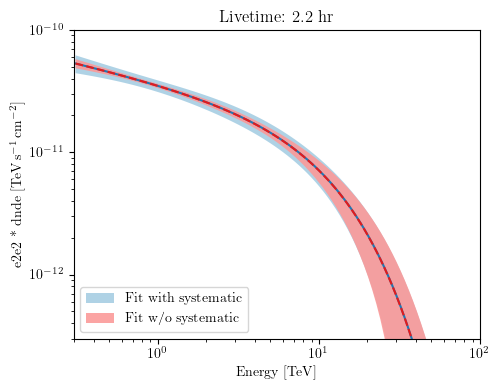

In [11]:
energy_power = 2
energy_bounds = (0.3, 100) *u.TeV
def plot_spectrum(i, ax):
    live = livetimes[i]
    print(live)

    dataset_N.models[0].spectral_model.plot(energy_bounds, energy_power = energy_power,
                                                 color = aw[0], ax = ax)    
    paris = [p.name for p in dataset_N.models[0].spectral_model.parameters.free_parameters]
    dataset_N.models[0].spectral_model.plot_error(energy_bounds,energy_power = energy_power, ax = ax, 
                                               facecolor= aw[1], alpha = 0.9, 
                                                 label = f'Fit with systematic')
    dataset.models[0].spectral_model.plot(energy_bounds,energy_power = energy_power, ax = ax, 
                                               color= awo[0], linestyle = 'dashed')

    dataset.models[0].spectral_model.plot_error(energy_bounds,energy_power = energy_power, ax = ax, 
                                               facecolor= awo[1], alpha = 0.9,
                                               label = f'Fit w/o systematic')
    ax.set_title(f"Livetime: {float(live):.2} hr")
    ax.set_ylim(3e-13, 1e-10)

    if i <2:
        ax.set_ylim(6e-13, 6e-9)


    idx = 2
    
    #idx = np.where(live == lives)[0]
    try:
        fpd_Ns[idx].data.plot(ax = ax, energy_power = energy_power, color = ew[0],
                             label = "Fluxpoint with \nsystematic and statistic",
                             capsize = 5)
        fpd_s[idx].data.plot(ax = ax, energy_power = energy_power, color = ewo[0],
                            label = "Fluxpoint w/o \nsystematic and with statistic",
                            capsize = 5,marker = 'x')
    except:
        pass
    ax.legend(loc = 'lower left')
    plt.tight_layout()
    ax.set_xlim(energy_bounds[0], energy_bounds[1])
    #ax.set_ylim(4e-13, 8e-11)
    
    yl = ax.get_ylabel()
    ax.set_ylabel("e2" + yl)#"dnde [$\mathrm{TeV\,s^{-1}\,cm^{-2}}$]}")
    return fig
        
i = 7 
fig,ax = plt.subplots(1, 1, figsize = (5, 4 ))

fig = plot_spectrum(i, ax)
fig.savefig(f'../{folder}/plots/{nbidx}_spectrum_{livetimes[i]}.pdf')

In [12]:
def compute_precision(N):
    Z = 1.645
    return Z / np.sqrt(N)

def plot_coverage(fig, ax2):
    p = compute_precision(N)
    ax2.errorbar(ebins, withine, yerr=p, color=awo[0], label="")
    ax2.errorbar(ebins * 1.05, withine_N, yerr=p, color=aw[0], label="")
    ax2.plot(ebins, [0.68] * len(ebins), ":", color="black", label="")
    # ax2.legend(ncol = 2)
    axs.set_title(f"N = {N} (p = {p*100:.3}\\%)")
    ax2.set_xlabel("Energy [TeV]")
    ax2.set_ylabel("Coverage")
    axs.set_xlabel("")
    plt.tight_layout()

In [13]:
N = len(flux2e)
N

1000

In [14]:
mask = dataset_input.mask.data.sum(axis=2).sum(axis=1) > 0
ebins = dataset_input.counts.geom.axes[0].center[mask]
i = 7
asimov, asimov_errors = dataset.models[0].spectral_model.evaluate_error(ebins)
asimov_N, asimov_errors_N = dataset_N.models[0].spectral_model.evaluate_error(
    ebins,
)


In [15]:


withine = []
withine_N = []

for ie, e in enumerate(ebins):
    xs = []
    xs_N = []
    for f in flux:
        value = f[ie]
        lowerlim = np.all(value <= asimov.value[ie] + asimov_errors.value[ie])
        upperlim = np.all(value >= asimov.value[ie] - asimov_errors.value[ie])
        x = lowerlim & upperlim
        xs.append(x)

        lowerlim = np.all(value <= asimov_N.value[ie] + asimov_errors_N.value[ie])
        upperlim = np.all(value >= asimov_N.value[ie] - asimov_errors_N.value[ie])
        x = lowerlim & upperlim
        xs_N.append(x)

    withine.append(np.count_nonzero(xs) / N)
    withine_N.append(np.count_nonzero(xs_N) / N)
print(withine)
print(withine_N)
print(np.mean(withine_N))

[0.291, 0.275, 0.272, 0.294, 0.295, 0.29, 0.26, 0.232, 0.236, 0.262, 0.337, 0.442, 0.601, 0.698, 0.74, 0.763, 0.787, 0.752, 0.723, 0.693]
[0.521, 0.581, 0.658, 0.694, 0.669, 0.585, 0.534, 0.511, 0.499, 0.506, 0.524, 0.586, 0.67, 0.714, 0.737, 0.746, 0.783, 0.751, 0.721, 0.692]
0.6340999999999999


2.154434690031884


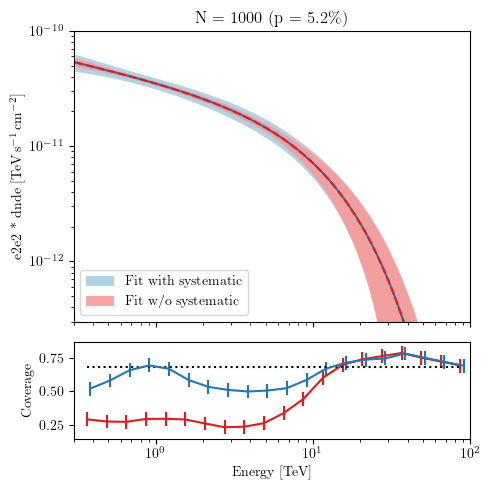

In [16]:
i = 7 
fig, (axs, ax2) = plt.subplots(
    2, 1, gridspec_kw={"height_ratios": [3, 1]}, sharex=True, figsize=((5, 5))
)
fig = plot_spectrum(i, axs)



energy_bounds = (0.3, 100) *u.TeV

plot_coverage(fig, ax2)
yy = axs.get_ylim()
#for f in flux2e:
#    axs.plot(ebins, f, color = 'grey', alpha = 0.2)
    
ax2.set_xscale("log")
#axs.set_ylim(yy[0], yy[1])
#axs.set_ylim(1e-12, yy[1])
#axs.set_ylim(1e-13, yy[1])
axs.set_xlabel("")
fig.savefig(f'../{folder}/plots/{nbidx}_spectrum_{livetimes[i]}.pdf')
